Example text processing (unstructured text data) with pyspark

word frequency in books. eg. Jane Austen's Pride and Prejudice. Look at `gutenberg_books/` folder

* Read — Read the input data (a plain text file).
* Token — Tokenize each word.
* Clean — Remove any punctuation and/or tokens that aren’t words. Lowercase each word.
* Count — Count the frequency of each word present in the text.
* Answer — Return the top 10 (or 20, 50, 100).

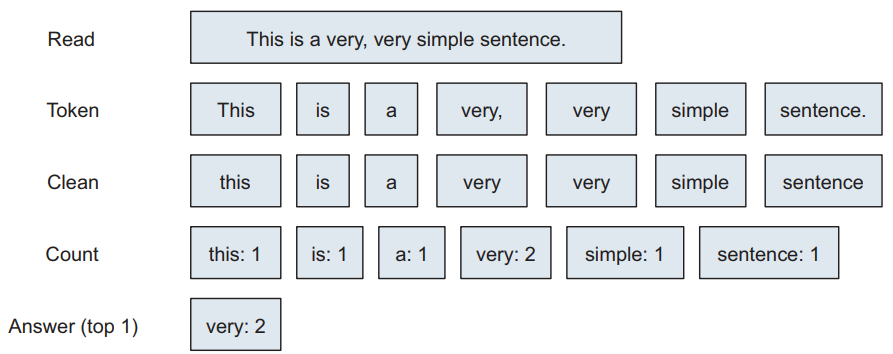

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark: SparkSession = (SparkSession
.builder
.appName("Analyzing the vocabulary of Pride and Prejudice.")
.getOrCreate())

In [4]:
# SparkSession is a wrapper arround the spark context and the previous sql context (SQLContext)
from pyspark import SparkContext

sqlContext = spark
sc: SparkContext = spark.sparkContext

.setLogLevel() - Control our logLevel. This overrides any user-defined log settings.
Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN

In [5]:
# setting the logging level
spark.sparkContext.setLogLevel("WARN")

In [6]:
# read data into a data frame with spark.read
spark.read

In [7]:
dir(spark.read)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_df',
 '_jreader',
 '_set_opts',
 '_spark',
 'csv',
 'format',
 'jdbc',
 'json',
 'load',
 'option',
 'options',
 'orc',
 'parquet',
 'schema',
 'table',
 'text']

In [8]:
print(spark.read.__doc__)


    Interface used to load a :class:`DataFrame` from external storage systems
    (e.g. file systems, key-value stores, etc). Use :attr:`SparkSession.read`
    to access this.

    .. versionadded:: 1.4
    


In [9]:
methods = [method for method in dir(spark.read) if not method.startswith('__')]
methods

['_df',
 '_jreader',
 '_set_opts',
 '_spark',
 'csv',
 'format',
 'jdbc',
 'json',
 'load',
 'option',
 'options',
 'orc',
 'parquet',
 'schema',
 'table',
 'text']

* spark.read.csv() will map to spark.read.format('csv').load()
* orc and parquet are also data formats that are especially well suited for big data processing. ORC (“optimized row columnar”) and Parquet are competing data formats that pretty much serve the same purpose.

In [10]:
from pyspark.sql import DataFrame

In [11]:
book: DataFrame = spark.read.text("./data/gutenberg_books/1342-0.txt")

In [12]:
book

DataFrame[value: string]

When working with a larger data frame (think hundreds or even thousands of columns), you may want to see the schema displayed more clearly. PySpark provides printSchema() to display the schema in a tree form

In [13]:
book.printSchema()

root
 |-- value: string (nullable = true)



In [14]:
print(book.dtypes)

[('value', 'string')]


In [15]:
# print data

book.head() # not what we want

Row(value='The Project Gutenberg EBook of Pride and Prejudice, by Jane Austen')

In [16]:
book.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This eBook is for...|
|almost no restric...|
|re-use it under t...|
|with this eBook o...|
|                    |
|                    |
|Title: Pride and ...|
|                    |
| Author: Jane Austen|
|                    |
|Posting Date: Aug...|
|Release Date: Jun...|
|Last Updated: Mar...|
|                    |
|   Language: English|
|                    |
|Character set enc...|
|                    |
+--------------------+
only showing top 20 rows



When ingesting our selected text into a data frame, PySpark created one record for each line of text and provided a value column of type String. 

In [17]:
book.show(n=10, truncate=False, vertical=False)

+--------------------------------------------------------------------+
|value                                                               |
+--------------------------------------------------------------------+
|The Project Gutenberg EBook of Pride and Prejudice, by Jane Austen  |
|                                                                    |
|This eBook is for the use of anyone anywhere at no cost and with    |
|almost no restrictions whatsoever.  You may copy it, give it away or|
|re-use it under the terms of the Project Gutenberg License included |
|with this eBook or online at www.gutenberg.org                      |
|                                                                    |
|                                                                    |
|Title: Pride and Prejudice                                          |
|                                                                    |
+--------------------------------------------------------------------+
only s

In [18]:
book.select('*').show(3) # SELECT * FROM book LIMIT 3;

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This eBook is for...|
+--------------------+
only showing top 3 rows



In [19]:
book.select(book.value).show(3) # SELECT value FROM book;

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This eBook is for...|
+--------------------+
only showing top 3 rows



In [20]:
from pyspark.sql.functions import col

In [21]:
# all ways of selecting the same thing
book.select(book.value)
book.select(book["value"])
book.select(col("value"))
book.select("value")

DataFrame[value: string]

To tokenize each word, we need to split each string into a list of distinct words. 

In [22]:
from pyspark.sql.functions import split

split() - Splits str around matches of the given pattern.

In [23]:
split(str=book.value, pattern=" ")

Column<'split(value,  , -1)'>

In [24]:
from pyspark.sql import Column

In [25]:
new_col: Column = split(str=book.value, pattern=" ")

In [26]:
lines = book.select(new_col)

In [27]:
lines.show(5)

+--------------------+
| split(value,  , -1)|
+--------------------+
|[The, Project, Gu...|
|                  []|
|[This, eBook, is,...|
|[almost, no, rest...|
|[re-use, it, unde...|
+--------------------+
only showing top 5 rows



In [28]:
lines.columns # weird column name

['split(value,  , -1)']

In [29]:
from pyspark.sql import Column

.alias() - Returns this column aliased with a new name or names (in the case of expressions that return more than one column, such as explode)

In [30]:
new_col = new_col.alias("line")

In [31]:
lines = book.select(new_col)

In [32]:
lines.show()

+--------------------+
|                line|
+--------------------+
|[The, Project, Gu...|
|                  []|
|[This, eBook, is,...|
|[almost, no, rest...|
|[re-use, it, unde...|
|[with, this, eBoo...|
|                  []|
|                  []|
|[Title:, Pride, a...|
|                  []|
|[Author:, Jane, A...|
|                  []|
|[Posting, Date:, ...|
|[Release, Date:, ...|
|[Last, Updated:, ...|
|                  []|
|[Language:, English]|
|                  []|
|[Character, set, ...|
|                  []|
+--------------------+
only showing top 20 rows



In [33]:
# another way of doing this

# lines = book.select(split(book.value, " "))
# lines = lines.withColumnRenamed("split(value, , -1)", "line")

Exploding a list into rows

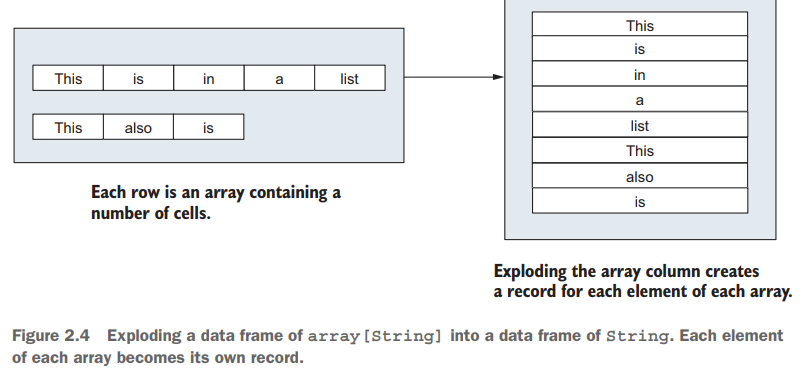

In [34]:
from pyspark.sql.functions import explode

In [35]:
words = lines.select(explode(col("line")).alias("word"))

In [36]:
words.show(15)

+----------+
|      word|
+----------+
|       The|
|   Project|
| Gutenberg|
|     EBook|
|        of|
|     Pride|
|       and|
|Prejudice,|
|        by|
|      Jane|
|    Austen|
|          |
|      This|
|     eBook|
|        is|
+----------+
only showing top 15 rows



Lower the case of the words in the data frame

In [37]:
from pyspark.sql.functions import lower

In [38]:
words_lower = words.select(lower(col("word")).alias("word_lower"))

In [39]:
words_lower.show(15)

+----------+
|word_lower|
+----------+
|       the|
|   project|
| gutenberg|
|     ebook|
|        of|
|     pride|
|       and|
|prejudice,|
|        by|
|      jane|
|    austen|
|          |
|      this|
|     ebook|
|        is|
+----------+
only showing top 15 rows



clean our words of any punctuation and other non-useful characters - in this case, we'll keep only the letters using a regular expression
* https://regexr.com/

In [40]:
from pyspark.sql.functions import regexp_extract

In [41]:
words_clean = words_lower.select(
    regexp_extract(col("word_lower"), "[a-z]+", 0).alias("word")
)

In [42]:
words_clean.show(15)

+---------+
|     word|
+---------+
|      the|
|  project|
|gutenberg|
|    ebook|
|       of|
|    pride|
|      and|
|prejudice|
|       by|
|     jane|
|   austen|
|         |
|     this|
|    ebook|
|       is|
+---------+
only showing top 15 rows



Filtering rows - blank cells shouldn’t be considered

In [43]:
words_nonull = words_clean.filter(col("word") != "")

In [44]:
words_nonull.show(15)

+---------+
|     word|
+---------+
|      the|
|  project|
|gutenberg|
|    ebook|
|       of|
|    pride|
|      and|
|prejudice|
|       by|
|     jane|
|   austen|
|     this|
|    ebook|
|       is|
|      for|
+---------+
only showing top 15 rows



we count the number of each word by creating groups: one for each word. Once those groups are formed, we can perform an aggregation function on each one of them. In this specific case, we count the number of records for each group, which will give us the number of occurrences for each word in the data frame. 

In [45]:
from pyspark.sql import GroupedData

In [46]:
# grouping records with groupBy()
groups: GroupedData = words_nonull.groupBy(col("word")) # or groupby()

In [47]:
groups

.count() - Counts the number of records for each group.

In [48]:
results: DataFrame = groups.count()
# SELECT count(*) FROM words_nonull GROUP BY "word";

In [49]:
results.show()

+-------------+-----+
|         word|count|
+-------------+-----+
|       online|    4|
|         some|  209|
|        still|   72|
|          few|   72|
|         hope|  122|
|        those|   60|
|     cautious|    4|
|    imitation|    1|
|          art|    3|
|      solaced|    1|
|       poetry|    2|
|    arguments|    5|
| premeditated|    1|
|      elevate|    1|
|       doubts|    2|
|    destitute|    1|
|    solemnity|    5|
|   lieutenant|    1|
|gratification|    1|
|    connected|   14|
+-------------+-----+
only showing top 20 rows



In [50]:
# ordering records with orderBy()
results.orderBy("count", ascending=False).show(10)

+----+-----+
|word|count|
+----+-----+
| the| 4496|
|  to| 4235|
|  of| 3719|
| and| 3602|
| her| 2223|
|   i| 2052|
|   a| 1997|
|  in| 1920|
| was| 1844|
| she| 1703|
+----+-----+
only showing top 10 rows



In [51]:
results.orderBy(col("count").desc()).show(10) # same thing

+----+-----+
|word|count|
+----+-----+
| the| 4496|
|  to| 4235|
|  of| 3719|
| and| 3602|
| her| 2223|
|   i| 2052|
|   a| 1997|
|  in| 1920|
| was| 1844|
| she| 1703|
+----+-----+
only showing top 10 rows



the English language needs pronouns and other common words. In natural language processing, those words are called stop words and could be removed

to save the dataframe to a csv,

In [52]:
# Don't do this because it will  write in multiple CSV files, one per partition
# results.write.csv("./data/simple_count.csv")

# To reduce the number of partitions, we apply the coalesce() method with the desired number of partitions
# results.coalesce(1).write.csv("./data/simple_count_single_partition.csv")

.coalesce() - Returns a new DataFrame that has exactly numPartitions partitions

In [53]:
coalesced_res:DataFrame = results.coalesce(1)

In [57]:
# well this gives me an error but it should work on Google Colab or the docker setup so I'm just going to ignore and skip this step
# coalesced_res.write.csv("./data/simple_count_single_partition.csv")

In [61]:
# and use this workaround (save the DataFrame locally using toPandas() and to_csv())
import pandas as pd
res_pandas_df: pd.DataFrame = coalesced_res.toPandas()

In [62]:
res_pandas_df.to_csv("./data/simple_count_single_partition.csv", index=False)

The final code would look like this:

In [58]:
import pyspark.sql.functions as F

results = (
    spark.read.text("./data/gutenberg_books/1342-0.txt")
        .select(F.split(F.col("value"), " ").alias("line"))
        .select(F.explode(F.col("line")).alias("word"))
        .select(F.lower(F.col("word")).alias("word"))
        .select(F.regexp_extract(F.col("word"), "[a-z']*", 0).alias("word"))
        .where(F.col("word") != "")
        .groupby("word")
        .count()
)

"""
# this is the same as 
results = spark.read.text('./data/ch02/1342-0.txt')\
    .select(F.split(F.col("value"), " ").alias("line"))\
    .select(F.explode(F.col("line")).alias("word"))\
    .select(F.lower(F.col("word")).alias("word"))\
    .select(F.regexp_extract(F.col("word"), "[a-z']*", 0).alias("word"))\
    .where(F.col("word") != "")\
    .groupby("word")\
    .count()
"""

In [60]:
results.show(5)

+------+-----+
|  word|count|
+------+-----+
|online|    4|
|  some|  203|
| still|   72|
|   few|   72|
|  hope|  122|
+------+-----+
only showing top 5 rows



some best pratices
* using a formatter. eg. https://black.readthedocs.io/en/stable/

* adhering to import conventions. eg. `import pyspark.sql.functions as F`

* chaining for writing over the same variable
```python
# instead of doing this
df = spark.read.text("./data/gutenberg_books/1342-0.txt")
df = df.select(F.split(F.col("value"), " ").alias("line"))

# do this
df = (
spark.read.text("./data/gutenberg_books/1342-0.txt")
.select(F.split(F.col("value"), " ").alias("line"))
)
```

Using spark-submit to launch your program in batch mode
* Spark provides a single program, named `spark-submit`, to submit Spark (Scala, Java, SQL), PySpark (Python), and SparkR (R) programs
* submit the program 

```bash 
spark-submit unstructured_text_submit.py
```